# Single Modal Distribution Lambda

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tfk.layers 
tfd = tfp.distributions
tfpl = tfp.layers

print("Tensorflow Version: %s" % tf.__version__)
print("Tensorflow Probability Version: %s" % tfp.__version__)

if tf.test.gpu_device_name() != '/device:GPU:0':
      print('GPU device not found. Using CPU')
else:
      print('Found GPU: {}'.format(tf.test.gpu_device_name()))

C:\Users\Tom\Anaconda3\envs\mltf2\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


Tensorflow Version: 2.0.0-beta1
Tensorflow Probability Version: 0.8.0-dev20190619
Found GPU: /device:GPU:0


In [2]:
# commons package
import os
import sys
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import commons as cm
importlib.reload(cm)

<module 'commons' from 'D:\\Tom\\Documents\\gitworkspace\\master\\ml-probability\\tfp_word_embeddings\\commons.py'>

# Configuration and Parameters

In [3]:
# GloVe Configuration

# Directory containing the GloVe files.
GLOVE_DIR = "D:/google drive/haw/master/mastertheisis/hauptprojekt"

# Embedding dimension
EMBEDDING_DIM = 50

In [4]:
setup = cm.setup(glove_dir=GLOVE_DIR, embedding_dim=EMBEDDING_DIM)
(x_train, x_train_padded, y_train) = setup["train"]
(x_test, x_test_padded, y_test) = setup["test"]
word_index = setup["word_index"]

Found 400000 word vectors.
17361/88587 unknown words


In [13]:
# Bayes by Backprop parameters

# hidden layers where each element denotes the number of neurons
n_hidden = [64, 64, 32]

# descriptive model name
model_name = "distribution_lambda_%s" % "_".join(map(str, n_hidden))

# model save file
model_save_file = "./models/%s.h5" % model_name

# history save file
history_save_file = "./history/%s.csv" % model_name

# number of data points
N = x_train.shape[0]

# batch size for training
batch_size = 128

# training epochs 
epochs = 20

# validation split
validation_split = 0.05

# History

In [15]:
(history_df, last_epoch) = cm.load_history_from_file(history_save_file=history_save_file)

Loaded history successfully. Last epoch: 20


# Model

In [11]:
# https://github.com/keras-team/keras/issues/5916

def negloglik(y, rv_y):
    return -rv_y.log_prob(y)

def create_model():
    model = tfk.Sequential()
    
    model.add(setup["embedding_layer"])
    
    for i in range(len(n_hidden)):
        model.add(tfkl.Dense(n_hidden[i], activation="relu"))
        model.add(tfkl.Dropout(0.25))
    
    model.add(tfkl.Flatten())
    model.add(tfkl.Dense(1 + 1))
    model.add(tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(1e-2 * t[...,1:]))))
    
    model.compile(optimizer=tfk.optimizers.Adam(0.001), loss=negloglik, metrics=cm.metrics)

    return model

try:
    model = tfk.models.load_model(model_save_file, custom_objects={'negloglik': negloglik})
    print("using saved model")
except IOError:
    model = create_model()
    print("model has not been trained (IOError)")
model.summary()

model has not been trained (IOError)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2697, 50)          4429400   
_________________________________________________________________
dense (Dense)                (None, 2697, 64)          3264      
_________________________________________________________________
dropout (Dropout)            (None, 2697, 64)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 2697, 64)          4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2697, 64)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 2697, 32)          2080      
_________________________________________________________________
dropout_2 (Dropout)

In [14]:
model.fit(x_train_padded, 
          y_train, 
          validation_split=validation_split,
          initial_epoch=last_epoch,
          epochs=epochs, 
          batch_size=batch_size,
          callbacks=cm.get_keras_callbacks(model_save_file=model_save_file, history_save_file=history_save_file))

Train on 23750 samples, validate on 1250 samples
Epoch 1/20
23750/23750 [==============================] - 32s 1ms/sample - loss: 0.9026 - acc: 0.5062 - true_negatives: 6171.0000 - false_negatives: 6025.0000 - true_positives: 5851.0000 - false_positives: 5703.0000 - precision: 0.5064 - recall: 0.4927 - kl: 2.2432 - val_loss: 0.7546 - val_acc: 0.5232 - val_true_negatives: 339.0000 - val_false_negatives: 309.0000 - val_true_positives: 315.0000 - val_false_positives: 287.0000 - val_precision: 0.5233 - val_recall: 0.5048 - val_kl: 1.9721
Epoch 2/20
23750/23750 [==============================] - 30s 1ms/sample - loss: 0.7181 - acc: 0.5432 - true_negatives: 6401.0000 - false_negatives: 5375.0000 - true_positives: 6501.0000 - false_positives: 5473.0000 - precision: 0.5429 - recall: 0.5474 - kl: 1.6421 - val_loss: 0.6371 - val_acc: 0.5744 - val_true_negatives: 365.0000 - val_false_negatives: 271.0000 - val_true_positives: 353.0000 - val_false_positives: 261.0000 - val_precision: 0.5749 - val_r

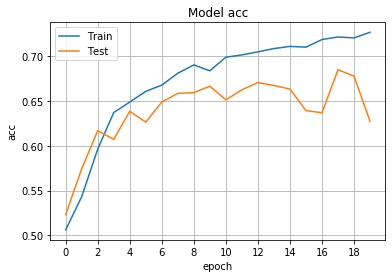

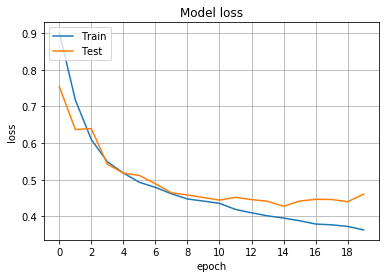

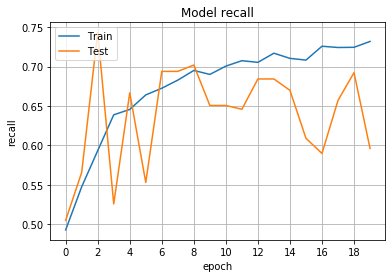

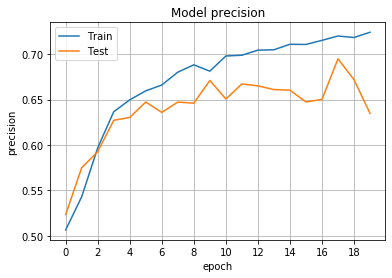

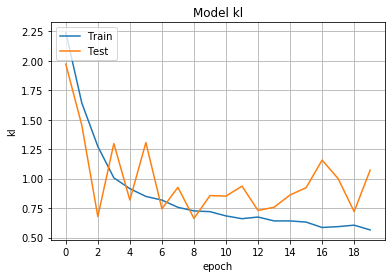

In [16]:
for metric in ["acc", "loss", "recall", "precision", "kl"] :
    cm.plot_metric(metric, history_df)
    plt.show()

D:\Tom\Documents\gitworkspace\master\ml-probability\tfp_word_embeddings\commons.py:263: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  ax.errorbar(x, y, yerr=yerr, fmt="o", elinewidth=1, color="black")


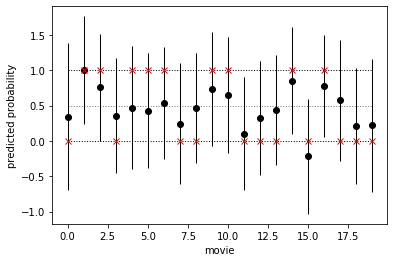

KL divergence: 3.37


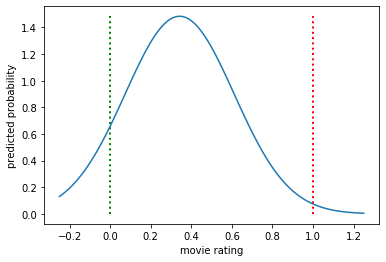

KL divergence: 0.67


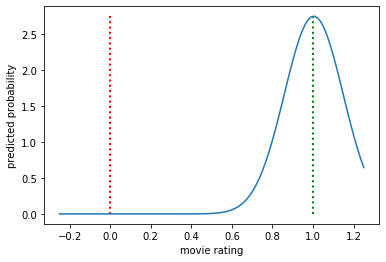

KL divergence: 1.37


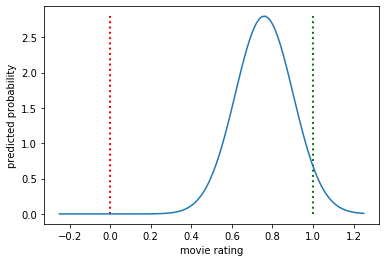

KL divergence: 2.43


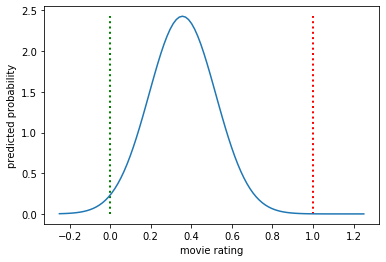

KL divergence: 4.59


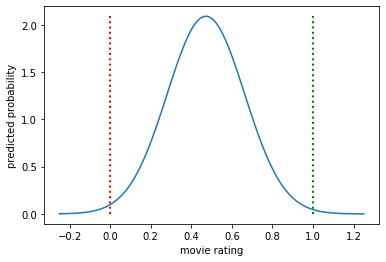

KL divergence: 4.89


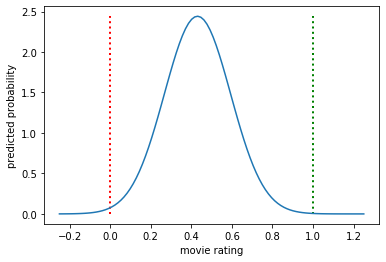

KL divergence: 3.51


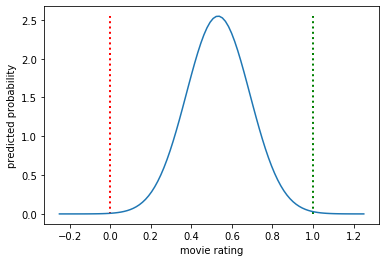

KL divergence: 1.78


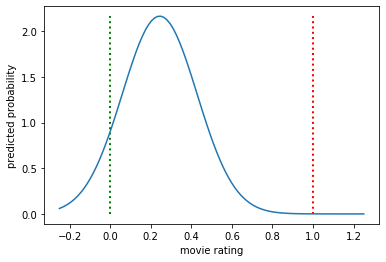

KL divergence: 3.49


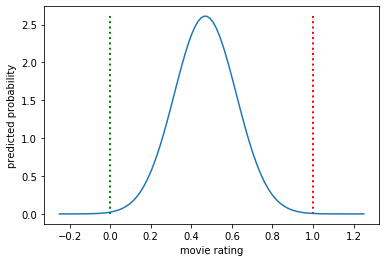

KL divergence: 1.72


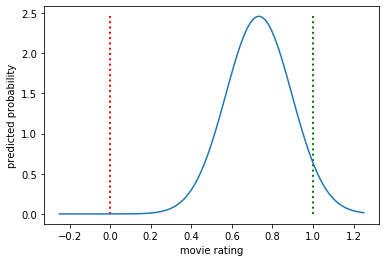

KL divergence: 2.41


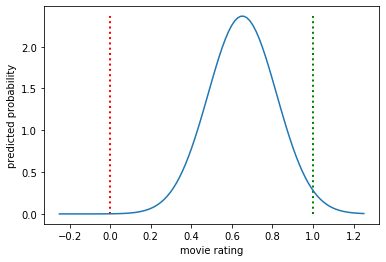

KL divergence: 0.94


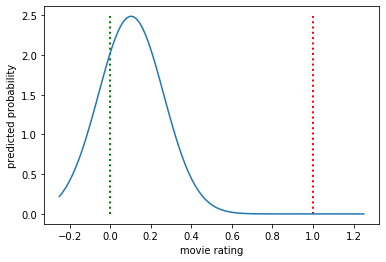

KL divergence: 2.10


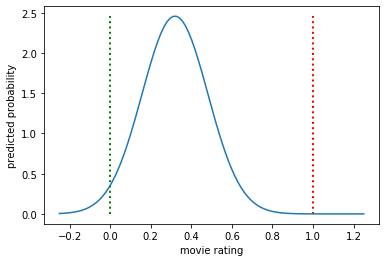

KL divergence: 3.12


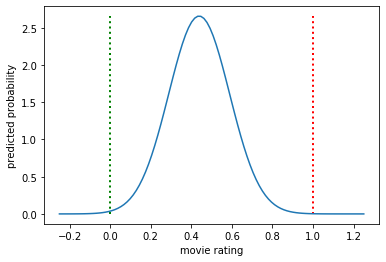

KL divergence: 0.92


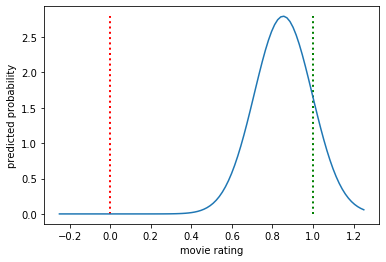

KL divergence: 1.46


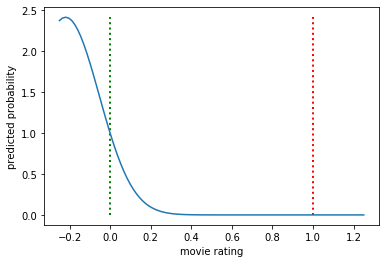

KL divergence: 1.15


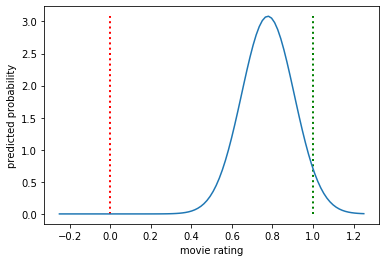

KL divergence: 5.15


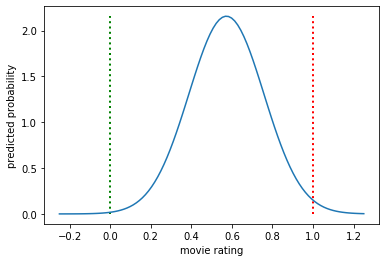

KL divergence: 1.44


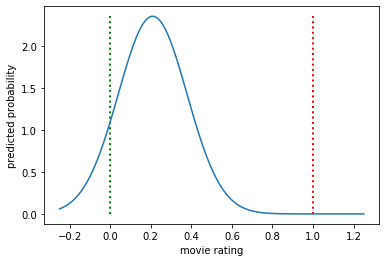

KL divergence: 2.02


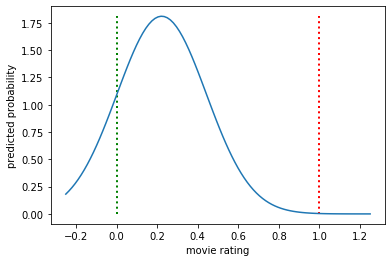

In [17]:
n_samples = 20
posterior = model(x_test_padded[:n_samples])
true_ys = y_test[:n_samples]

def create_pdf(mu, sigma):
    Z =  (2 * 3.1415 * sigma**2) ** 0.5
    return lambda x: tf.exp(-0.5 * (x - mu)**2 / sigma**2) / Z

def plot_independent(posterior, true_ys):
    for (mu, sigma, true_y) in zip(posterior.mean(), posterior.variance(), true_ys):
        dist = tfd.Normal(loc=mu, scale=tf.sqrt(sigma))
        pdf = create_pdf(mu, sigma)
        x = np.linspace(-0.25, 1.25, 100)
        y = np.array([pdf(x1) for x1 in x])
        y_max = np.max(y)

        true_dist = tfd.Normal(loc=float(true_y), scale=0.2)
        print("KL divergence: %.2f" % dist.kl_divergence(true_dist).numpy()[0])

        fig, ax = plt.subplots()
        ax.plot(x, y)
        color0 = ['g', 'r'][true_y]
        color1 = ['g', 'r'][1 - true_y]
        ax.vlines(x=[0, 1], ymin=0, ymax=y_max, linewidth=2, color=[color0, color1], linestyle=":")
        plt.xlabel("movie rating")
        plt.ylabel("predicted probability")

        plt.show()
        
good_ratings = np.extract(true_ys == 1, posterior.mean().numpy()) 
bad_ratings = np.extract(true_ys == 1, posterior.mean().numpy())

cm.plot_confidence(posterior.mean(), posterior.stddev(), true_ys)
plot_independent(posterior, true_ys)